> ## Introduction:

The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class (5000 for training and 1000 for testing purpose). In this notebook, I try to implement different autoencoders as feature extractor and using those features as inputs to a classifier model, I try to predict the different classes of images in the CIFAR-10 dataset. There is also one more handicap. I used only 50% of the images (3000 images per class) for training and the rest 50% for testing for the following 3 classes: bird, deer and truck. So, the training data is imbalanced.

I used both general convolutional autoencoder and [U-net](https://arxiv.org/pdf/1505.04597.pdf) model as autoencoder for feature extraction purpose. For the classifier model, I used both simple stacked dense layers and also convolution layers and then dense layers. I used hyperopt library to find out the optimized hyperparameters for the classifier model. I also used the class-weight function from the sklearn.utils library for using different class weights to tackle the imbalanced training data.

I found that, U-net architecture (with connector layers) is vastly superior as autoencoders compared to general convolutional autoencoders. But using the features generated from the U-net architecture resulted in low accuracy for the classifier models.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

import keras
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, MaxPool2D, Flatten, BatchNormalization
from keras.layers import Conv1D, MaxPool1D, CuDNNLSTM, Reshape
from keras.layers import Input, Dense, Dropout, Activation, Add, Concatenate
from keras.datasets import cifar10
from keras import regularizers
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import SGD, Adam, RMSprop, Adadelta
import keras.backend as K
from keras.objectives import mean_squared_error
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, RobustScaler, StandardScaler

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

Using TensorFlow backend.


## Load Data:

I used the keras datasets library to load the training and testing data.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


I created the following dictionary for using it later in visualizations.

In [3]:
dict = {0:'Airplane', 1:'Automobile', 2:'Bird', 3:'Cat', 4:'Deer', 5:'Dog', 6:'Frog', 7:'Horse', 8:'Ship', 9:'Truck'}

## Creating imbalanced data:

I just used the first 2000 images of the bird, deer and truck classes from the training data as test data. In this process, I has 3000 images in both training and test dataset for these 3 classes.

In [4]:
x_test_extra = []
y_test_extra = []
x_train_final = []
y_train_final = []
count = [0, 0, 0]
for i, j in zip(x_train, y_train):
    if (j==2):
        if(count[0]<2000):
            x_test_extra.append(i)
            y_test_extra.append(j)
            count[0]+=1
        else:
            x_train_final.append(i)
            y_train_final.append(j)
    elif (j==4):
        if(count[1]<2000):
            x_test_extra.append(i)
            y_test_extra.append(j)
            count[1]+=1
        else:
            x_train_final.append(i)
            y_train_final.append(j)
    elif (j==9):
        if(count[2]<2000):
            x_test_extra.append(i)
            y_test_extra.append(j)
            count[2]+=1
        else:
            x_train_final.append(i)
            y_train_final.append(j)
    else:
        x_train_final.append(i)
        y_train_final.append(j)
        
x_test_extra = np.array(x_test_extra)
y_test_extra = np.array(y_test_extra)
x_train_final = np.array(x_train_final)
y_train_final = np.array(y_train_final)

In [5]:
x_test_final = np.append(x_test_extra, x_test, axis=0)
y_test_final = np.append(y_test_extra, y_test, axis=0)

## Data Normalization:

Data was normalized because neural networks work better with normalized data.

In [6]:
#x_train_final = x_train    ## These code were used to check model performances with balanced dataset.
#x_test_final = x_test
#y_train_final = y_train
#y_test_final = y_test
x_train_final = x_train_final.astype('float32')
x_test_final = x_test_final.astype('float32')
x_train_final = x_train_final / 255
x_test_final = x_test_final / 255

## Validation split:

I used 20% of the training data as validation set. Validation data was chosen randomly.

In [7]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_trainf, y_validf = train_test_split(x_train_final, y_train_final, test_size=0.2, random_state=42, shuffle= True)

## Target conversion to categorical:

The target variable was converted to one-hot encoded data using the utils.to_categorical function of the keras library.

In [8]:
y_train = keras.utils.to_categorical(y_trainf, 10)
y_valid = keras.utils.to_categorical(y_validf, 10)
y_test_one_hot = keras.utils.to_categorical(y_test_final, 10)

## Necessary functions:

In [9]:
def create_block(input, chs): ## Convolution block of 2 layers
    x = input
    for i in range(2):
        x = Conv2D(chs, 3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
    return x

##############################

## Here, I compute the class weights for using in different models. 
## This is to order our model to emphasize more on classes with less training data.
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(y_trainf), 
                y_trainf.reshape(y_trainf.shape[0]))

class_weights

##############################

def showOrigDec(orig, dec, num=10):  ## function used for visualizing original and reconstructed images of the autoencoder model
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[300*i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[300*i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
        
def show_test(m, d):  ## function used for visualizing the predicted and true labels of test data
    plt.figure(figsize =(40,8))
    for i in range(5):
        ax = plt.subplot(1, 5, i+1)
        test_image = np.expand_dims(d[1810*i+5], axis=0)
        test_result = m.predict(test_image)
        plt.imshow(x_test_final[1810*i+5])
        index = np.argsort(test_result[0,:])
        plt.title("Pred:{}, True:{}".format(dict[index[9]], dict[y_test_final[1810*i+5][0]]))
    plt.show()
    
def show_test2(m, d):  ## function used for visualizing the predicted and true labels of test data
    plt.figure(figsize =(40,8))
    for i in range(5):
        ax = plt.subplot(1, 5, i+1)
        test_image = np.expand_dims(d[1810*i+5], axis=0)
        test_result = m.predict(test_image)[1]
        plt.imshow(x_test_final[1810*i+5])
        index = np.argsort(test_result[0,:])
        plt.title("Pred:{}, True:{}".format(dict[index[9]], dict[y_test_final[1810*i+5][0]]))
    plt.show()
    
def report(predictions): ## function used for creating a classification report and confusion matrix
    cm=confusion_matrix(y_test_one_hot.argmax(axis=1), predictions.argmax(axis=1))
    print("Classification Report:\n")
    cr=classification_report(y_test_one_hot.argmax(axis=1),
                                predictions.argmax(axis=1), 
                                target_names=list(dict.values()))
    print(cr)
    plt.figure(figsize=(12,12))
    sns.heatmap(cm, annot=True, xticklabels = list(dict.values()), yticklabels = list(dict.values()), fmt="d")
    
def loss_function(y_true, y_pred):  ## loss function for using in autoencoder models
    mses = mean_squared_error(y_true, y_pred)
    return K.sum(mses, axis=(1,2))

## Simple Convolution Model as Classifier:

Here, I have a model that uses several convolution layers stacked and followed by a dense layer with 10 output nodes and softmax activation. It is used as a single classifier model that I can use as a benchmark model. Dropout layers are used for reducing overfitting.

In [10]:
def full_conv():
    input = Input((32,32,3))
    block1 = create_block(input, 32)
    x = MaxPool2D(2)(block1)
    #x = Dropout(0.2)(x)
    block2 = create_block(x, 64)
    x = MaxPool2D(2)(block2)
    #x = Dropout(0.3)(x)
    block3 = create_block(x, 128)
    #x = MaxPool2D(2)(block3)
    x = Dropout(0.4)(block3)
    x = Flatten()(x)
    output = Dense(10, activation='softmax')(x)
    return Model(input, output)

conv_model = full_conv()
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
__________

In [11]:
#training
batch_size = 512
epochs=50
opt_rms = Adadelta()
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=opt_rms,
                   metrics=['accuracy'])

In [12]:
def run_conv_model(data_aug):
    er = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
    lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_delta=0.0001)
    callbacks = [er, lr]
    
    if not data_aug:
        history = conv_model.fit(x_train, y_train, batch_size=512,
                                 epochs=epochs,
                                 verbose=1, callbacks=callbacks,
                                 validation_data=(x_valid,y_valid),
                                 class_weight=class_weights)
    else:
        train_datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
        train_set_ae = train_datagen.flow(x_train, y_train, batch_size=512)

        validation_datagen = ImageDataGenerator()
        validation_set_ae = validation_datagen.flow(x_valid, y_valid, batch_size=512)
        
        history = conv_model.fit_generator(train_set_ae,
                                           epochs=epochs,
                                           steps_per_epoch=np.ceil(x_train.shape[0]/512),
                                           verbose=1, callbacks=callbacks,
                                           validation_data=(validation_set_ae),
                                           validation_steps=np.ceil(x_valid.shape[0]/512),
                                           class_weight=class_weights)
        
        return history

In [13]:
run_conv_model(1)

Epoch 1/50
69/69 [==============================] - 15s 213ms/step - loss: 2.0252 - acc: 0.4215 - val_loss: 1.5986 - val_acc: 0.4806
Epoch 2/50
69/69 [==============================] - 12s 170ms/step - loss: 1.3017 - acc: 0.5626 - val_loss: 1.4849 - val_acc: 0.5372
Epoch 3/50
69/69 [==============================] - 12s 174ms/step - loss: 1.1291 - acc: 0.6183 - val_loss: 1.2071 - val_acc: 0.6031
Epoch 4/50
69/69 [==============================] - 12s 175ms/step - loss: 0.9985 - acc: 0.6588 - val_loss: 1.1516 - val_acc: 0.6136
Epoch 5/50
69/69 [==============================] - 12s 177ms/step - loss: 0.9088 - acc: 0.6897 - val_loss: 0.9610 - val_acc: 0.6744
Epoch 6/50
69/69 [==============================] - 12s 177ms/step - loss: 0.8463 - acc: 0.7150 - val_loss: 0.8860 - val_acc: 0.7026
Epoch 7/50
69/69 [==============================] - 12s 176ms/step - loss: 0.7944 - acc: 0.7312 - val_loss: 0.8225 - val_acc: 0.7184
Epoch 8/50
69/69 [==============================] - 12s 176ms/step - 

In [14]:
print('Test accuracy for benchmark model= {}'.format(conv_model.evaluate(x_test_final, y_test_one_hot)[1]))

16000/16000 [==============================] - 1s 83us/step
Test accuracy for benchmark model= 0.8065


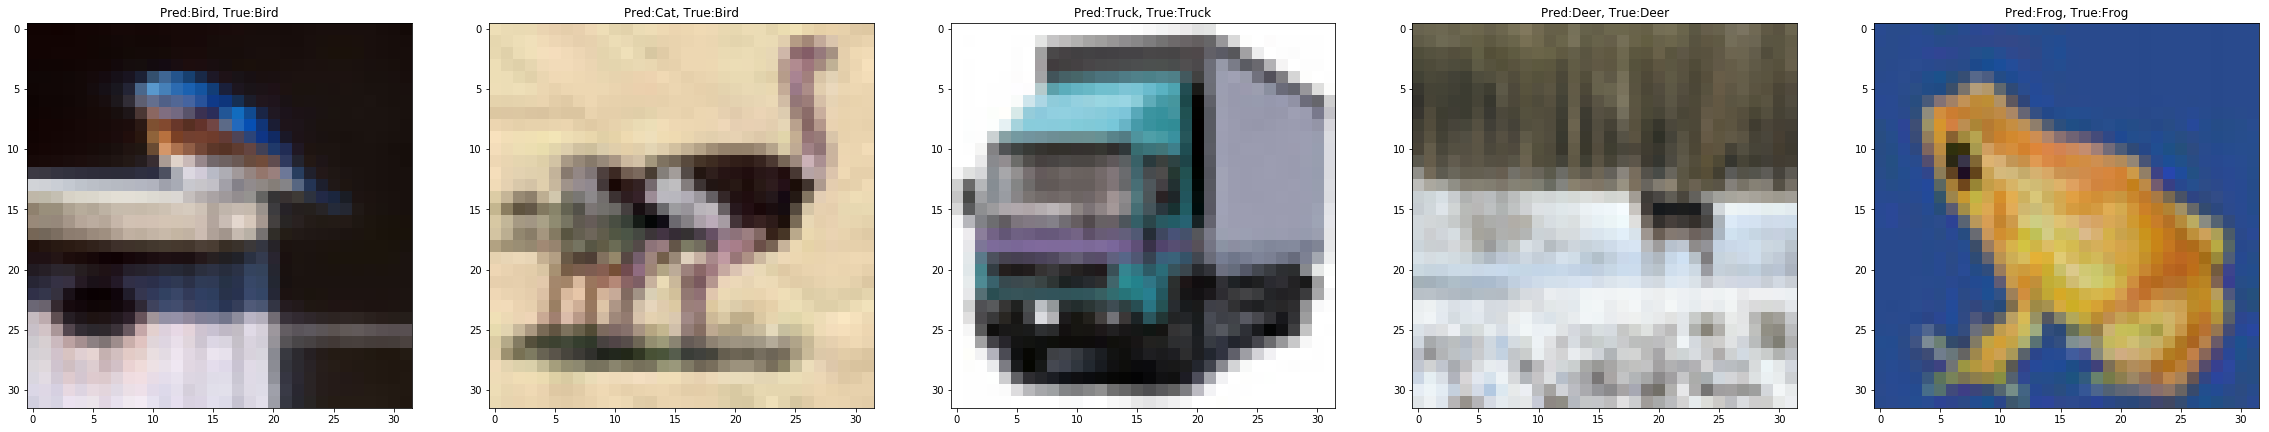

In [15]:
show_test(conv_model, x_test_final)

Classification Report:

              precision    recall  f1-score   support

    Airplane       0.67      0.89      0.76      1000
  Automobile       0.75      0.95      0.83      1000
        Bird       0.93      0.66      0.77      3000
         Cat       0.60      0.69      0.64      1000
        Deer       0.91      0.76      0.83      3000
         Dog       0.67      0.77      0.72      1000
        Frog       0.67      0.93      0.77      1000
       Horse       0.70      0.89      0.78      1000
        Ship       0.86      0.90      0.88      1000
       Truck       0.95      0.87      0.91      3000

    accuracy                           0.81     16000
   macro avg       0.77      0.83      0.79     16000
weighted avg       0.83      0.81      0.81     16000



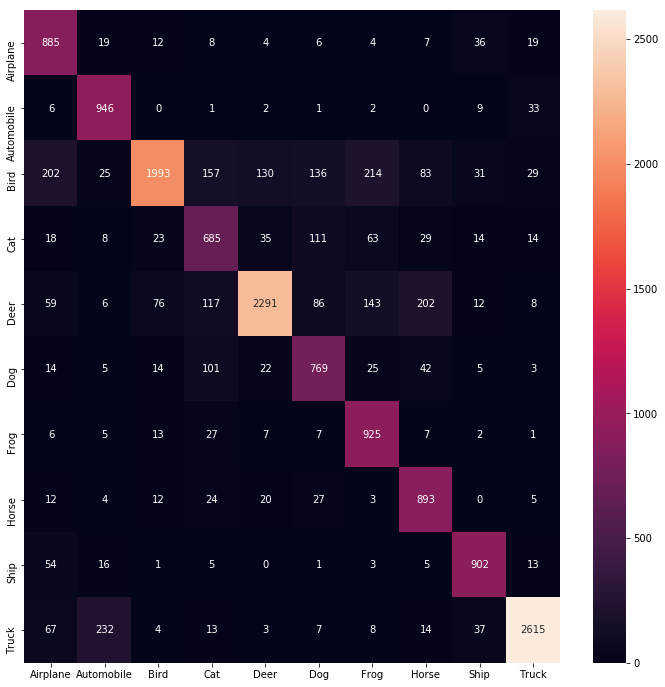

In [16]:
predictions = conv_model.predict(x_test_final)
report(predictions)

From the confusion matrix, we can see that, the model works quite good with only 50 epochs for all the classes inspite of the imbalanced data. It only had problem identifying birds correctly. I found that, the result was worse when I did not use class weights. The model accuracy is also improved by augmenting data.

## Autoencoder Model:

In [17]:
def unet():  ## I commented several layers of the model for descreasing model complexity as the results were almost same
    input = Input((32,32,3))
    
    # Encoder
    block1 = create_block(input, 32)
    x = MaxPool2D(2)(block1)
    block2 = create_block(x, 64)
    x = MaxPool2D(2)(block2)
    #block3 = create_block(x, 64)
    #x = MaxPool2D(2)(block3)
    #block4 = create_block(x, 128)
    
    # Middle
    #x = MaxPool2D(2)(block2)
    middle = create_block(x, 128)
    
    # Decoder
    #x = Conv2DTranspose(128, kernel_size=2, strides=2)(middle)
    #x = Concatenate()([block4, x])
    #x = create_block(x, 128)
    #x = Conv2DTranspose(64, kernel_size=2, strides=2)(x)
    #x = Concatenate()([block3, x])
    #x = create_block(x, 64)
    x = Conv2DTranspose(64, kernel_size=2, strides=2)(middle)
    x = Concatenate()([block2, x])
    x = create_block(x, 64)
    x = Conv2DTranspose(32, kernel_size=2, strides=2)(x)
    x = Concatenate()([block1, x])
    x = create_block(x, 32)
    
    # output
    x = Conv2D(3, 1)(x)
    output = Activation("sigmoid")(x)
    
    return Model(input, middle), Model(input, output)

def general_ae():
    input = Input((32,32,3))
    
    # Encoder
    block1 = create_block(input, 32)
    x = MaxPool2D(2)(block1)
    block2 = create_block(x, 64)
    x = MaxPool2D(2)(block2)
    
    #Middle
    middle = create_block(x, 128)
    
    # Decoder
    up1 = UpSampling2D((2,2))(middle)
    block3 = create_block(up1, 64)
    #up1 = UpSampling2D((2,2))(block3)
    up2 = UpSampling2D((2,2))(block3)
    block4 = create_block(up2, 32)
    #up2 = UpSampling2D((2,2))(block4)
    
    # output
    x = Conv2D(3, 1)(up2)
    output = Activation("sigmoid")(x)
    return Model(input, middle), Model(input, output)

In [18]:
def run_ae(m):  ## function for choosing unet/general autoencoder
    if m=='unet':
        encoder, model = unet()
    elif m=='ae':
        encoder, model = general_ae()
        
    return encoder, model

## Implementing U-Net:

In [19]:
encoder_unet, model_unet = run_ae('unet')
model_unet.compile(SGD(1e-3, 0.9), loss=loss_function)
model_unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 32, 32, 32)   0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 32, 32, 32)   128         activation_7[0][0]               
__________________________________________________________________________________________________
conv2d_8 (

In [20]:
er = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_delta=0.0001)
callbacks = [er, lr]
history = model_unet.fit(x_train, x_train, 
                         batch_size=512,
                         epochs=100,
                         verbose=1,
                         validation_data=(x_valid, x_valid),
                         shuffle=True, callbacks=callbacks,
                         class_weight=class_weights)

Train on 35200 samples, validate on 8800 samples
Epoch 1/100
35200/35200 [==============================] - 8s 236us/step - loss: 7.8127 - val_loss: 5.8677
Epoch 2/100
35200/35200 [==============================] - 6s 172us/step - loss: 1.8319 - val_loss: 2.6806
Epoch 3/100
35200/35200 [==============================] - 6s 173us/step - loss: 1.1768 - val_loss: 2.2757
Epoch 4/100
35200/35200 [==============================] - 6s 172us/step - loss: 0.9336 - val_loss: 1.8065
Epoch 5/100
35200/35200 [==============================] - 6s 172us/step - loss: 0.8108 - val_loss: 1.0655
Epoch 6/100
35200/35200 [==============================] - 6s 173us/step - loss: 0.7157 - val_loss: 0.8831
Epoch 7/100
35200/35200 [==============================] - 6s 173us/step - loss: 0.6540 - val_loss: 0.6443
Epoch 8/100
35200/35200 [==============================] - 6s 172us/step - loss: 0.6051 - val_loss: 0.6613
Epoch 9/100
35200/35200 [==============================] - 6s 172us/step - loss: 0.5634 - val_l

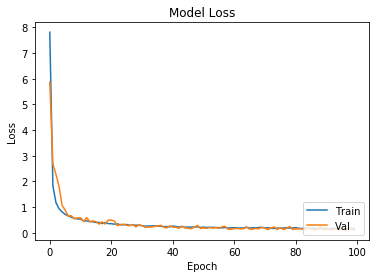

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [22]:
recon_test_unet = model_unet.predict(x_test_final)
recon_valid_unet = model_unet.predict(x_valid)

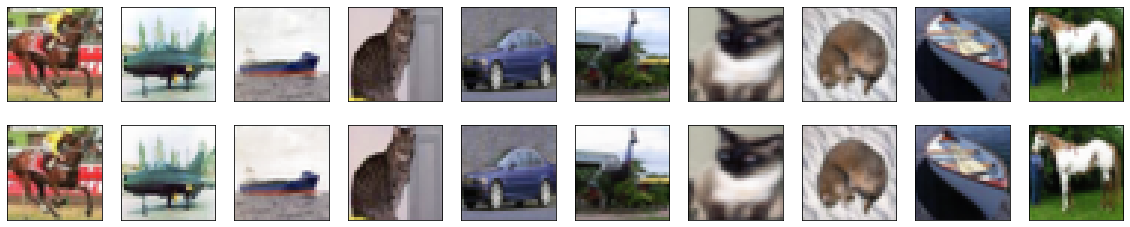

In [23]:
showOrigDec(x_valid, recon_valid_unet)

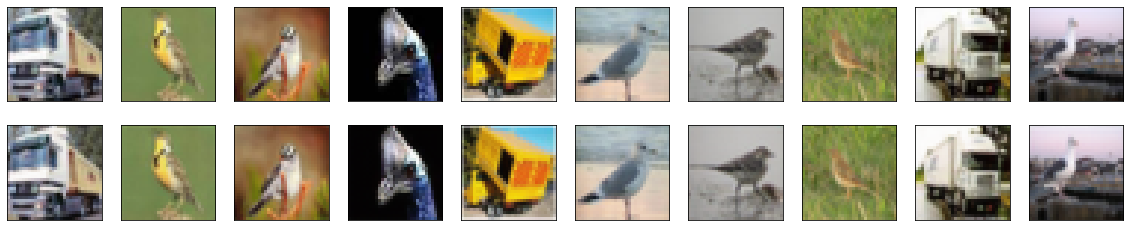

In [24]:
showOrigDec(x_test_final, recon_test_unet)

## Implement Convolutional AE:

In [25]:
encoder_ae, model_ae = run_ae('ae')
model_ae.compile(SGD(1e-3, 0.9), loss=loss_function)
model_ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_18 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 32)        128       
__________

In [26]:
er = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_delta=0.0001)
callbacks = [er, lr]
history = model_ae.fit(x_train, x_train, 
                       batch_size=512,
                       epochs=100,
                       verbose=1,
                       validation_data=(x_valid, x_valid),
                       shuffle=True, callbacks=callbacks,
                       class_weight=class_weights)

Train on 35200 samples, validate on 8800 samples
Epoch 1/100
35200/35200 [==============================] - 6s 176us/step - loss: 16.6599 - val_loss: 10.6312
Epoch 2/100
35200/35200 [==============================] - 4s 125us/step - loss: 9.2112 - val_loss: 8.8181
Epoch 3/100
35200/35200 [==============================] - 4s 125us/step - loss: 8.2937 - val_loss: 8.0346
Epoch 4/100
35200/35200 [==============================] - 4s 124us/step - loss: 7.7668 - val_loss: 7.7054
Epoch 5/100
35200/35200 [==============================] - 4s 124us/step - loss: 7.4490 - val_loss: 7.2828
Epoch 6/100
35200/35200 [==============================] - 4s 125us/step - loss: 7.1754 - val_loss: 7.2031
Epoch 7/100
35200/35200 [==============================] - 4s 125us/step - loss: 6.9424 - val_loss: 6.9978
Epoch 8/100
35200/35200 [==============================] - 4s 125us/step - loss: 6.7930 - val_loss: 6.7703
Epoch 9/100
35200/35200 [==============================] - 4s 125us/step - loss: 6.6604 - val

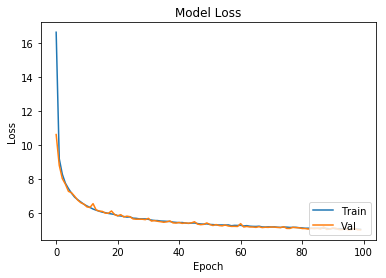

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [28]:
recon_test_ae = model_ae.predict(x_test_final)
recon_valid_ae = model_ae.predict(x_valid)

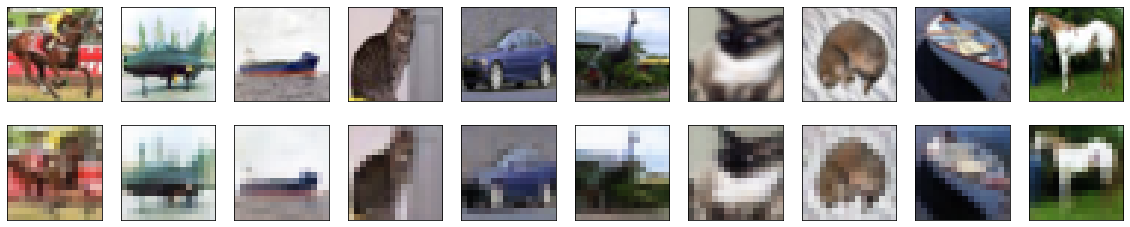

In [29]:
showOrigDec(x_valid, recon_valid_ae)

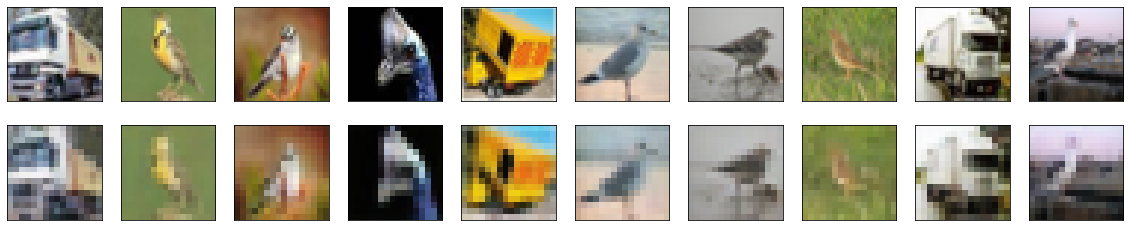

In [30]:
showOrigDec(x_test_final, recon_test_ae)

As we can see, unet architecture is far better in terms of reconstructing the data.

## Extracting bottleneck features to use as inputs in the classifier model:

In [31]:
gist_train_unet = encoder_unet.predict(x_train)
gist_valid_unet = encoder_unet.predict(x_valid)
gist_test_unet = encoder_unet.predict(x_test_final)

gist_train_ae = encoder_ae.predict(x_train)
gist_valid_ae = encoder_ae.predict(x_valid)
gist_test_ae = encoder_ae.predict(x_test_final)

## Classifier Models:

In [32]:
def classifier_dense(inp):
    input = Input((inp.shape[1], inp.shape[2], inp.shape[3]))
    #x = MaxPool2D()(input)
    x = Flatten()(input)
    #x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.64)(x)
    x = Dense(50, activation='relu')(x)
    #x = Reshape((-1, 1))(x)
    #x = Conv1D(128, (3,), activation='relu', padding='same')(x)
    #x = MaxPool1D()(x)
    #x = CuDNNLSTM(64)(x)
    #x = Flatten()(x)
    x = Dropout(0.4)(x)
    output = Dense(10, activation='softmax')(x)
    return Model(input, output)

def classifier_conv(inp):
    input = Input((inp.shape[1], inp.shape[2], inp.shape[3]))
    x = Conv2D(1024, 3, padding="same")(input)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)
    x = Dropout(0.5)(x)
    x = Conv2D(128, 3, padding="same")(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.35)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.69)(x)
    output = Dense(10, activation='softmax')(x)
    return Model(input, output)

In [33]:
def run_cls(m, inp):  ## function for choosing dense/convolutional classifier model
    if m=='dense':
        classifier = classifier_dense(inp)
    elif m=='conv':
        classifier = classifier_conv(inp)
        
    return classifier

## Convolutional AE with convolutional NN as classifier:

In [34]:
decoder_ae_conv = run_cls('conv', gist_train_ae)
decoder_ae_conv.compile(loss='categorical_crossentropy',
                        optimizer=Adadelta(),
                        metrics=['accuracy'])
decoder_ae_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 8, 8, 1024)        1180672   
_________________________________________________________________
activation_29 (Activation)   (None, 8, 8, 1024)        0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 8, 8, 1024)        4096      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 1024)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 4, 4, 128)         1179776   
__________

In [35]:
er = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_delta=0.0001)
callbacks = [er, lr]
hist1 = decoder_ae_conv.fit(gist_train_ae, y_train, batch_size=512, epochs=100, 
                            validation_data = (gist_valid_ae, y_valid),
                            shuffle=True, callbacks=callbacks,
                            class_weight=class_weights)

Train on 35200 samples, validate on 8800 samples
Epoch 1/100
35200/35200 [==============================] - 5s 148us/step - loss: 2.2603 - acc: 0.2088 - val_loss: 1.7900 - val_acc: 0.3556
Epoch 2/100
35200/35200 [==============================] - 3s 88us/step - loss: 1.8993 - acc: 0.3019 - val_loss: 1.6280 - val_acc: 0.3909
Epoch 3/100
35200/35200 [==============================] - 3s 88us/step - loss: 1.7420 - acc: 0.3662 - val_loss: 1.5447 - val_acc: 0.4190
Epoch 4/100
35200/35200 [==============================] - 3s 87us/step - loss: 1.6378 - acc: 0.4041 - val_loss: 1.4531 - val_acc: 0.4700
Epoch 5/100
35200/35200 [==============================] - 3s 88us/step - loss: 1.5686 - acc: 0.4318 - val_loss: 1.3284 - val_acc: 0.5092
Epoch 6/100
35200/35200 [==============================] - 3s 87us/step - loss: 1.4913 - acc: 0.4643 - val_loss: 1.3235 - val_acc: 0.5082
Epoch 7/100
35200/35200 [==============================] - 3s 86us/step - loss: 1.4343 - acc: 0.4869 - val_loss: 1.2720 - 

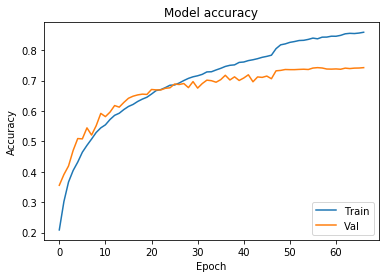

In [36]:
plt.plot(hist1.history['acc'])
plt.plot(hist1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [37]:
print('Test accuracy for AE_conv model= {}'.format(decoder_ae_conv.evaluate(gist_test_ae, y_test_one_hot)[1]))

16000/16000 [==============================] - 2s 99us/step
Test accuracy for AE_conv model= 0.6869375


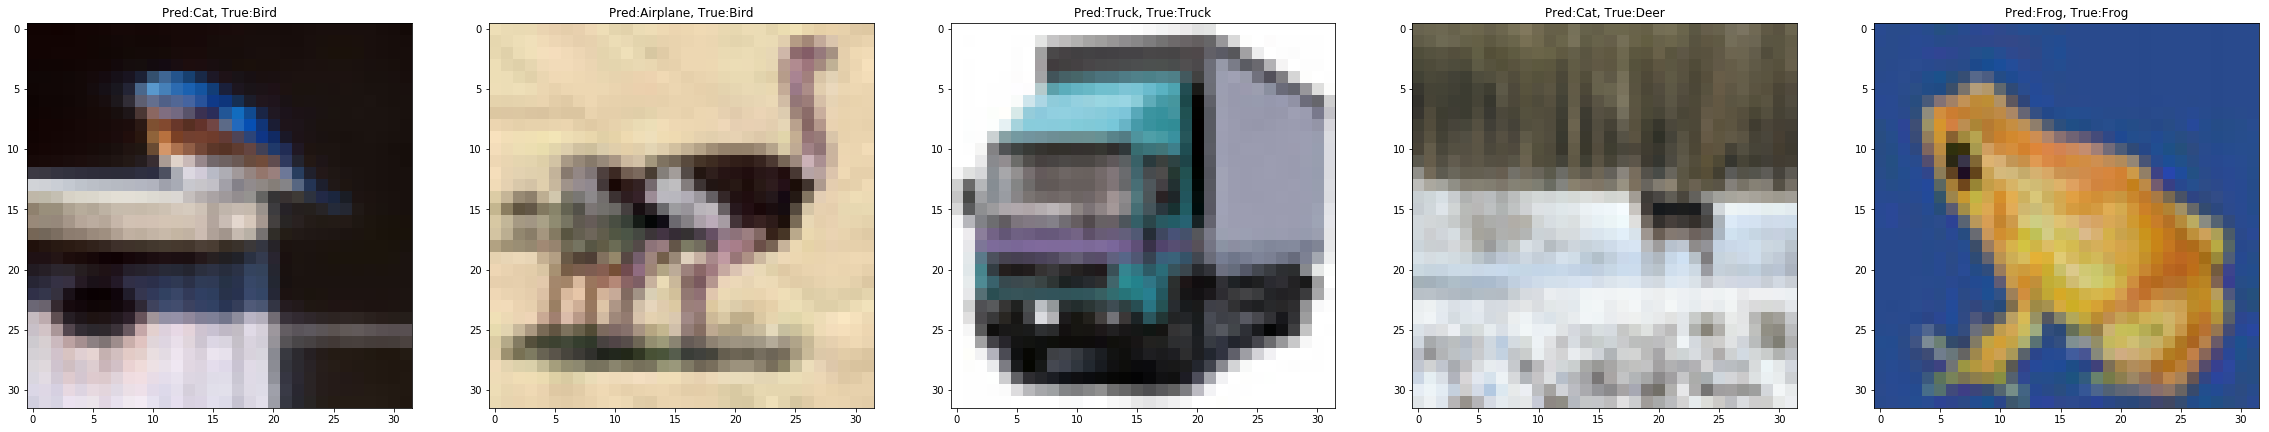

In [38]:
show_test(decoder_ae_conv, gist_test_ae)

Classification Report:

              precision    recall  f1-score   support

    Airplane       0.57      0.81      0.67      1000
  Automobile       0.67      0.86      0.75      1000
        Bird       0.85      0.47      0.60      3000
         Cat       0.39      0.53      0.45      1000
        Deer       0.79      0.64      0.71      3000
         Dog       0.51      0.65      0.57      1000
        Frog       0.56      0.86      0.68      1000
       Horse       0.57      0.81      0.67      1000
        Ship       0.76      0.86      0.81      1000
       Truck       0.93      0.76      0.83      3000

    accuracy                           0.69     16000
   macro avg       0.66      0.73      0.67     16000
weighted avg       0.73      0.69      0.69     16000



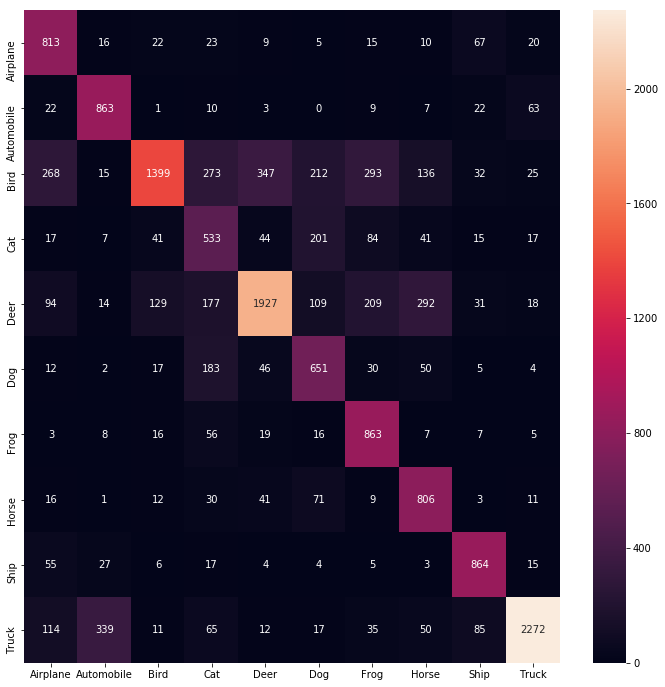

In [39]:
predictions = decoder_ae_conv.predict(gist_test_ae)
report(predictions)

## Convolutional AE with simple NN as classifier:

In [40]:
decoder_ae_dense = run_cls('dense', gist_train_ae)
decoder_ae_dense.compile(loss='categorical_crossentropy',
                         optimizer=Adadelta(),
                         metrics=['accuracy'])
decoder_ae_dense.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                25650     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
Total para

In [41]:
er = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_delta=0.0001)
callbacks = [er, lr]
hist1 = decoder_ae_dense.fit(gist_train_ae, y_train, batch_size=512, epochs=100, 
                             validation_data = (gist_valid_ae, y_valid),
                             shuffle=True, callbacks=callbacks,
                             class_weight=class_weights)

Train on 35200 samples, validate on 8800 samples
Epoch 1/100
35200/35200 [==============================] - 2s 64us/step - loss: 2.2269 - acc: 0.2582 - val_loss: 1.8000 - val_acc: 0.3856
Epoch 2/100
35200/35200 [==============================] - 1s 30us/step - loss: 1.8366 - acc: 0.3517 - val_loss: 1.5406 - val_acc: 0.4556
Epoch 3/100
35200/35200 [==============================] - 1s 30us/step - loss: 1.7161 - acc: 0.3924 - val_loss: 1.5057 - val_acc: 0.4802
Epoch 4/100
35200/35200 [==============================] - 1s 31us/step - loss: 1.6253 - acc: 0.4237 - val_loss: 1.4446 - val_acc: 0.4852
Epoch 5/100
35200/35200 [==============================] - 1s 31us/step - loss: 1.5521 - acc: 0.4508 - val_loss: 1.3705 - val_acc: 0.5286
Epoch 6/100
35200/35200 [==============================] - 1s 30us/step - loss: 1.4926 - acc: 0.4696 - val_loss: 1.3225 - val_acc: 0.5332
Epoch 7/100
35200/35200 [==============================] - 1s 30us/step - loss: 1.4358 - acc: 0.4883 - val_loss: 1.2810 - v

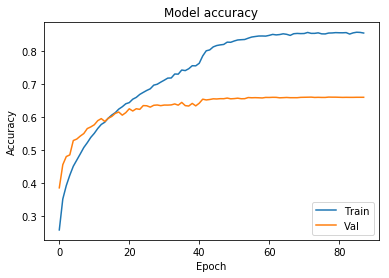

In [42]:
plt.plot(hist1.history['acc'])
plt.plot(hist1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [43]:
print('Test accuracy for AE_dense model= {}'.format(decoder_ae_dense.evaluate(gist_test_ae, y_test_one_hot)[1]))

16000/16000 [==============================] - 1s 63us/step
Test accuracy for AE_dense model= 0.5868125


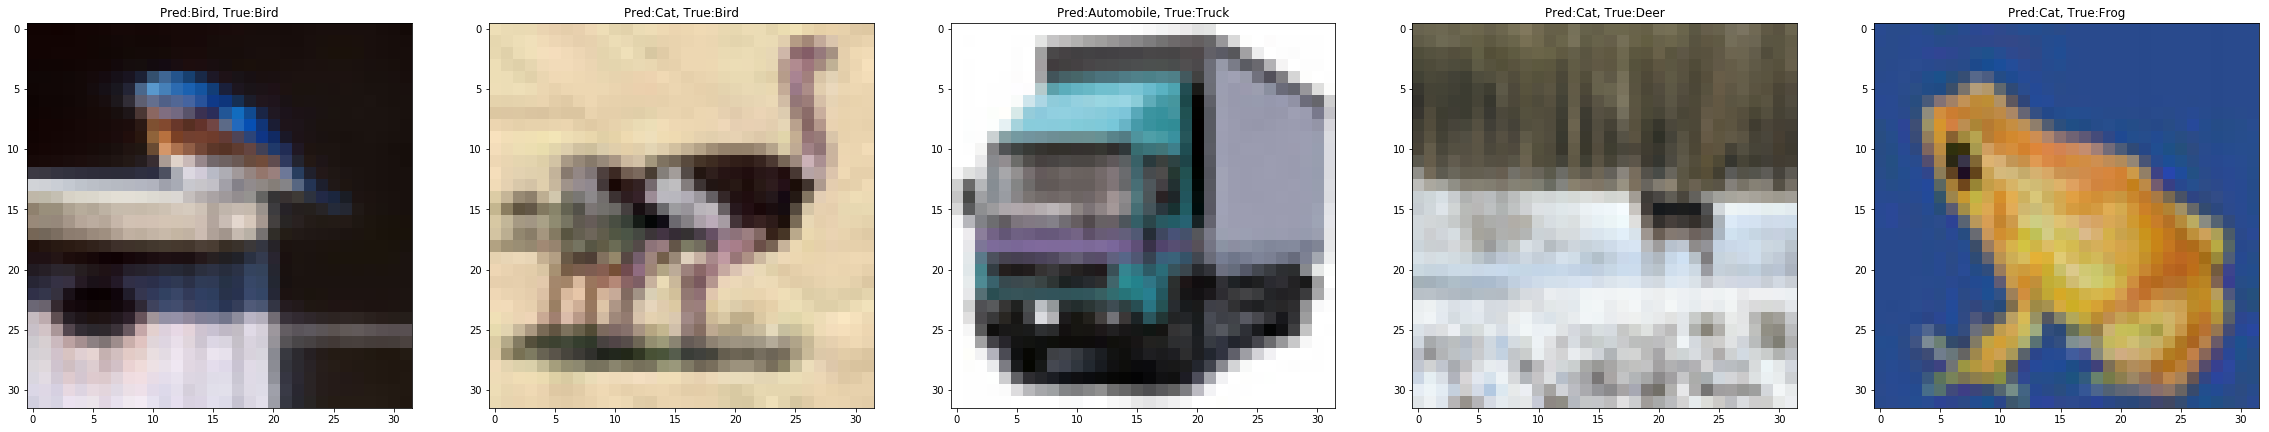

In [44]:
show_test(decoder_ae_dense, gist_test_ae)

Classification Report:

              precision    recall  f1-score   support

    Airplane       0.49      0.76      0.60      1000
  Automobile       0.51      0.81      0.62      1000
        Bird       0.71      0.41      0.52      3000
         Cat       0.30      0.54      0.39      1000
        Deer       0.75      0.48      0.59      3000
         Dog       0.42      0.56      0.48      1000
        Frog       0.50      0.78      0.61      1000
       Horse       0.51      0.72      0.60      1000
        Ship       0.66      0.78      0.72      1000
       Truck       0.90      0.59      0.72      3000

    accuracy                           0.59     16000
   macro avg       0.58      0.64      0.58     16000
weighted avg       0.66      0.59      0.59     16000



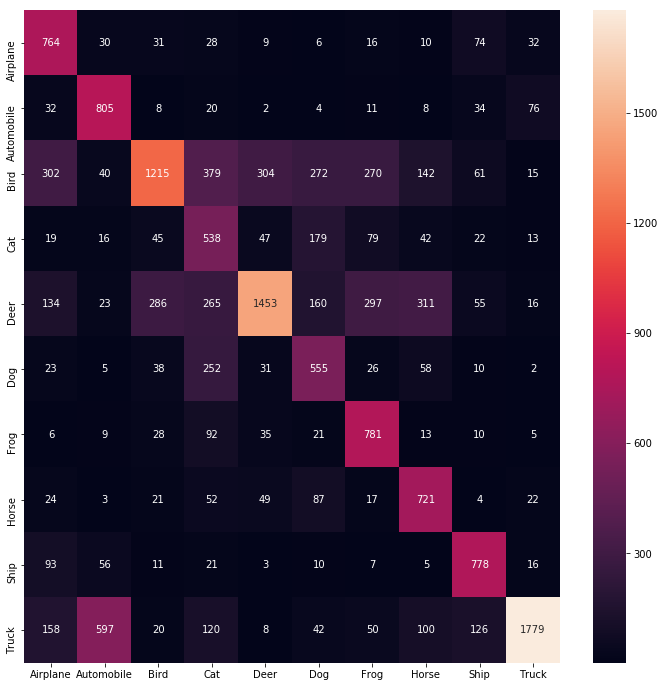

In [45]:
predictions = decoder_ae_dense.predict(gist_test_ae)
report(predictions)

## Unet with convolutional NN as classifier:

In [46]:
decoder_un_conv = run_cls('conv', gist_train_unet)
decoder_un_conv.compile(loss='categorical_crossentropy',
                         optimizer=Adadelta(),
                         metrics=['accuracy'])
decoder_un_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 8, 8, 1024)        1180672   
_________________________________________________________________
activation_31 (Activation)   (None, 8, 8, 1024)        0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 8, 8, 1024)        4096      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 1024)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 4, 4, 128)         1179776   
__________

In [47]:
er = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_delta=0.0001)
callbacks = [er, lr]
hist1 = decoder_un_conv.fit(gist_train_unet, y_train, batch_size=512, epochs=100, 
                            validation_data = (gist_valid_unet, y_valid),
                            shuffle=True, callbacks=callbacks,
                            class_weight=class_weights)

Train on 35200 samples, validate on 8800 samples
Epoch 1/100
35200/35200 [==============================] - 5s 137us/step - loss: 2.3776 - acc: 0.1670 - val_loss: 2.0203 - val_acc: 0.2672
Epoch 2/100
35200/35200 [==============================] - 3s 87us/step - loss: 2.0576 - acc: 0.2418 - val_loss: 1.8402 - val_acc: 0.3215
Epoch 3/100
35200/35200 [==============================] - 3s 87us/step - loss: 1.9440 - acc: 0.2861 - val_loss: 1.6880 - val_acc: 0.3689
Epoch 4/100
35200/35200 [==============================] - 3s 87us/step - loss: 1.8362 - acc: 0.3295 - val_loss: 1.6761 - val_acc: 0.3655
Epoch 5/100
35200/35200 [==============================] - 3s 87us/step - loss: 1.7636 - acc: 0.3635 - val_loss: 1.5554 - val_acc: 0.4316
Epoch 6/100
35200/35200 [==============================] - 3s 87us/step - loss: 1.6813 - acc: 0.3963 - val_loss: 1.4844 - val_acc: 0.4553
Epoch 7/100
35200/35200 [==============================] - 3s 87us/step - loss: 1.6319 - acc: 0.4124 - val_loss: 1.5075 - 

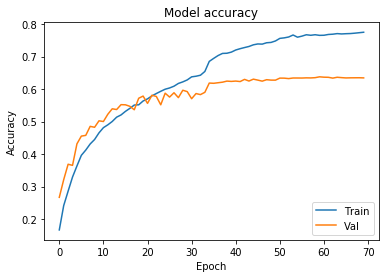

In [48]:
plt.plot(hist1.history['acc'])
plt.plot(hist1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [49]:
print('Test accuracy for Unet_conv model= {}'.format(decoder_un_conv.evaluate(gist_test_unet, y_test_one_hot)[1]))

16000/16000 [==============================] - 2s 98us/step
Test accuracy for Unet_conv model= 0.5550625


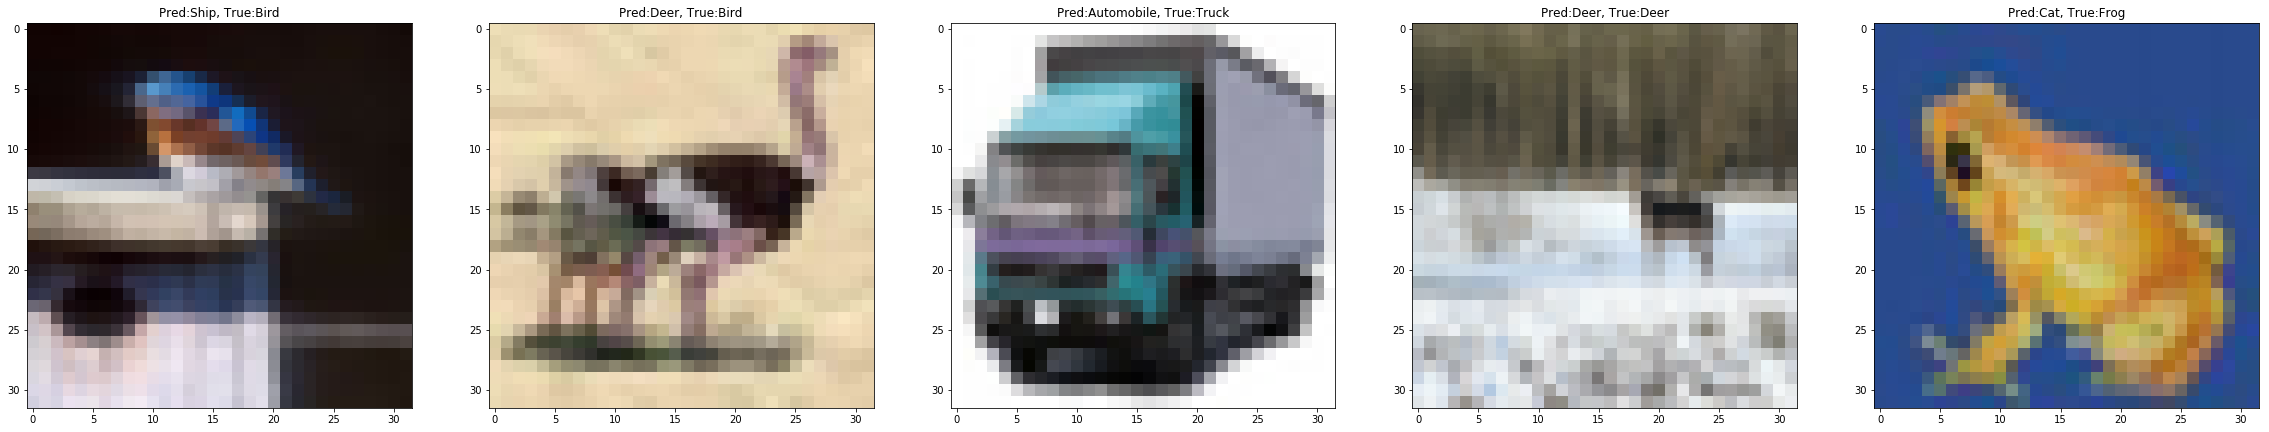

In [50]:
show_test(decoder_un_conv, gist_test_unet)

Classification Report:

              precision    recall  f1-score   support

    Airplane       0.48      0.71      0.58      1000
  Automobile       0.52      0.76      0.62      1000
        Bird       0.68      0.35      0.46      3000
         Cat       0.28      0.44      0.34      1000
        Deer       0.69      0.43      0.53      3000
         Dog       0.37      0.56      0.44      1000
        Frog       0.45      0.77      0.57      1000
       Horse       0.46      0.70      0.56      1000
        Ship       0.61      0.77      0.68      1000
       Truck       0.87      0.61      0.71      3000

    accuracy                           0.56     16000
   macro avg       0.54      0.61      0.55     16000
weighted avg       0.62      0.56      0.56     16000



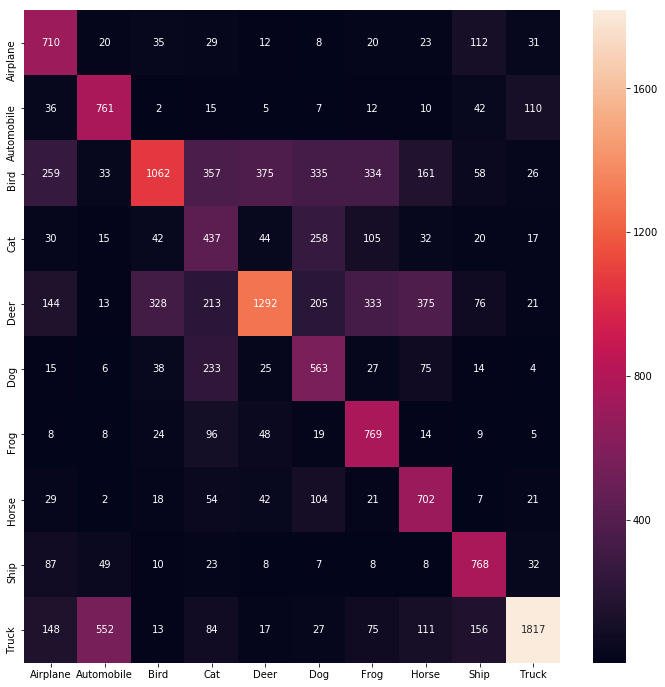

In [51]:
predictions = decoder_un_conv.predict(gist_test_unet)
report(predictions)

## Unet with simple NN as classifier:

In [52]:
decoder_un_dense = run_cls('dense', gist_train_unet)
decoder_un_dense.compile(loss='categorical_crossentropy',
                         optimizer=Adadelta(),
                         metrics=['accuracy'])
decoder_un_dense.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                25650     
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                510       
Total para

In [53]:
er = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_delta=0.0001)
callbacks = [er, lr]
hist1 = decoder_un_dense.fit(gist_train_unet, y_train, batch_size=512, epochs=100, 
                             validation_data = (gist_valid_unet, y_valid),
                             shuffle=True, callbacks=callbacks,
                             class_weight=class_weights)

Train on 35200 samples, validate on 8800 samples
Epoch 1/100
35200/35200 [==============================] - 3s 73us/step - loss: 2.3251 - acc: 0.2353 - val_loss: 1.8924 - val_acc: 0.3655
Epoch 2/100
35200/35200 [==============================] - 1s 31us/step - loss: 1.9491 - acc: 0.3112 - val_loss: 1.7122 - val_acc: 0.4125
Epoch 3/100
35200/35200 [==============================] - 1s 31us/step - loss: 1.8202 - acc: 0.3549 - val_loss: 1.6084 - val_acc: 0.4312
Epoch 4/100
35200/35200 [==============================] - 1s 31us/step - loss: 1.7279 - acc: 0.3848 - val_loss: 1.5656 - val_acc: 0.4595
Epoch 5/100
35200/35200 [==============================] - 1s 31us/step - loss: 1.6519 - acc: 0.4151 - val_loss: 1.4796 - val_acc: 0.4742
Epoch 6/100
35200/35200 [==============================] - 1s 31us/step - loss: 1.5811 - acc: 0.4360 - val_loss: 1.4430 - val_acc: 0.4940
Epoch 7/100
35200/35200 [==============================] - 1s 31us/step - loss: 1.5315 - acc: 0.4528 - val_loss: 1.4172 - v

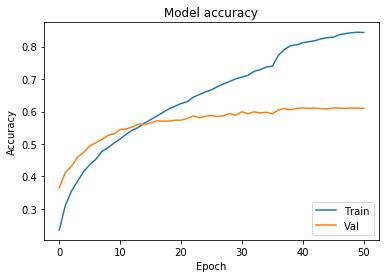

In [54]:
plt.plot(hist1.history['acc'])
plt.plot(hist1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [55]:
print('Test accuracy for Unet_dense model= {}'.format(decoder_un_dense.evaluate(gist_test_unet, y_test_one_hot)[1]))

16000/16000 [==============================] - 1s 61us/step
Test accuracy for Unet_dense model= 0.5364375


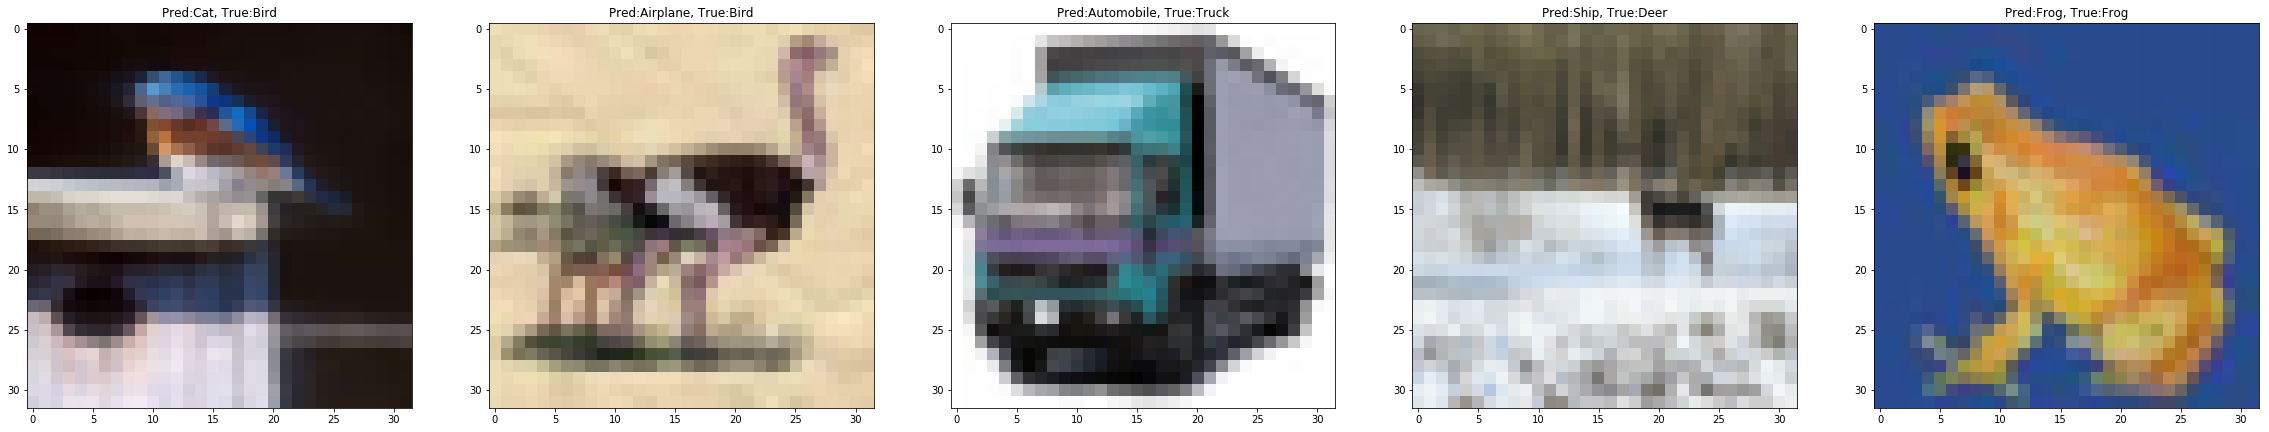

In [56]:
show_test(decoder_un_dense, gist_test_unet)

Classification Report:

              precision    recall  f1-score   support

    Airplane       0.45      0.69      0.54      1000
  Automobile       0.46      0.76      0.58      1000
        Bird       0.69      0.35      0.46      3000
         Cat       0.30      0.51      0.38      1000
        Deer       0.69      0.42      0.52      3000
         Dog       0.38      0.53      0.44      1000
        Frog       0.45      0.72      0.55      1000
       Horse       0.43      0.68      0.53      1000
        Ship       0.57      0.74      0.65      1000
       Truck       0.86      0.55      0.67      3000

    accuracy                           0.54     16000
   macro avg       0.53      0.60      0.53     16000
weighted avg       0.61      0.54      0.54     16000



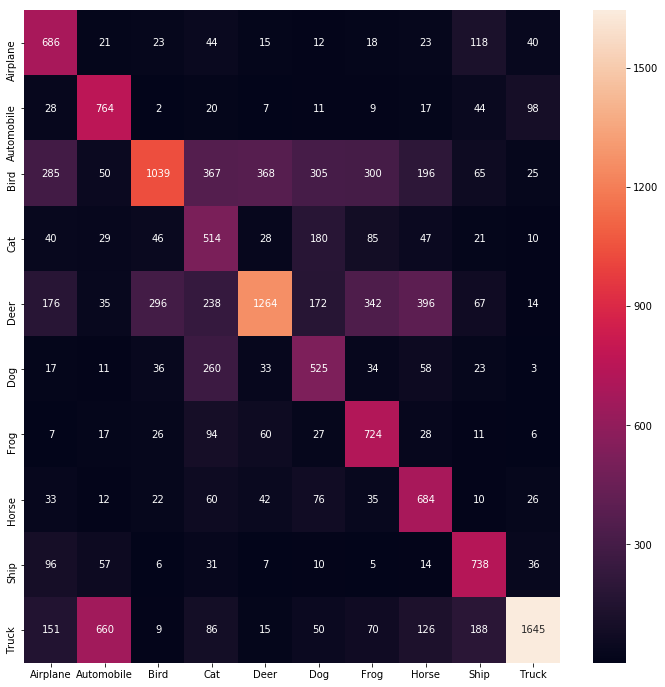

In [57]:
predictions = decoder_un_dense.predict(gist_test_unet)
report(predictions)

## Multi-output Model:

In [58]:
def end_to_end():  ## I commented several layers of the model for descreasing model complexity as the results were almost same
    input = Input((32,32,3))
    
    # Encoder
    block1 = create_block(input, 32)
    x = MaxPool2D(2)(block1)
    block2 = create_block(x, 64)
    x = MaxPool2D(2)(block2)
    #block3 = create_block(x, 64)
    #x = MaxPool2D(2)(block3)
    #block4 = create_block(x, 128)
    
    # Middle
    #x = MaxPool2D(2)(block2)
    middle = create_block(x, 128)
    
    # Decoder
    #x = Conv2DTranspose(128, kernel_size=2, strides=2)(middle)
    #x = Concatenate()([block4, x])
    #x = create_block(x, 128)
    #x = Conv2DTranspose(64, kernel_size=2, strides=2)(x)
    #x = Concatenate()([block3, x])
    #x = create_block(x, 64)
    x = Conv2DTranspose(64, kernel_size=2, strides=2)(middle)
    x = Concatenate()([block2, x])
    x = create_block(x, 64)
    x = Conv2DTranspose(32, kernel_size=2, strides=2)(x)
    x = Concatenate()([block1, x])
    x = create_block(x, 32)
    
    # reconstruction
    x = Conv2D(3, 1)(x)
    recon = Activation("sigmoid", name='autoencoder')(x)
    
    #classification 
    c = Conv2D(1024, 3, padding="same")(middle)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    c = MaxPool2D(2)(c)
    c = Dropout(0.5)(c)
    c = Conv2D(128, 3, padding="same")(c)
    c = Activation('relu')(c)
    c = BatchNormalization()(c)
    c = MaxPool2D(2)(c)
    c = Dropout(0.4)(c)
    c = Flatten()(c)
    c = Dense(512, activation='relu')(c)
    c = Dropout(0.35)(c)
    c = Dense(100, activation='relu')(c)
    c = Dropout(0.69)(c)
    classify = Dense(10, activation='softmax', name='classification')(c)
    
    outputs = [recon, classify]
    
    return Model(input, outputs)


In [59]:
multimodel = end_to_end()
multimodel.compile(loss = {'classification': 'categorical_crossentropy', 'autoencoder': loss_function}, 
                  loss_weights = {'classification': 0.9, 'autoencoder': 0.1}, 
                  optimizer = SGD(lr= 0.01, momentum= 0.9),
                  metrics = {'classification': ['accuracy'], 'autoencoder': []})

In [60]:
er = EarlyStopping(monitor='val_classification_acc', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_classification_acc', factor=0.2, patience=5, min_delta=0.0001)
callbacks = [er, lr]
hist_mul = multimodel.fit(x_train, [x_train,y_train], batch_size=512, epochs=100, 
                          validation_data = (x_valid, [x_valid,y_valid]),
                          shuffle=True, callbacks=callbacks)
#                           class_weight=class_weights

Train on 35200 samples, validate on 8800 samples
Epoch 1/100
35200/35200 [==============================] - 12s 348us/step - loss: 3.0621 - autoencoder_loss: 8.9444 - classification_loss: 2.4085 - classification_acc: 0.1622 - val_loss: 2.6419 - val_autoencoder_loss: 7.8851 - val_classification_loss: 2.0593 - val_classification_acc: 0.2508
Epoch 2/100
35200/35200 [==============================] - 8s 241us/step - loss: 2.1031 - autoencoder_loss: 2.8973 - classification_loss: 2.0148 - classification_acc: 0.2374 - val_loss: 1.9186 - val_autoencoder_loss: 3.0252 - val_classification_loss: 1.7956 - val_classification_acc: 0.3249
Epoch 3/100
35200/35200 [==============================] - 8s 241us/step - loss: 1.8830 - autoencoder_loss: 2.1284 - classification_loss: 1.8558 - classification_acc: 0.2910 - val_loss: 1.8231 - val_autoencoder_loss: 3.1280 - val_classification_loss: 1.6781 - val_classification_acc: 0.3409
Epoch 4/100
35200/35200 [==============================] - 8s 240us/step - lo

In [61]:
recon_test_e2e = multimodel.predict(x_test_final)[0]
recon_valid_e2e = multimodel.predict(x_valid)[0]

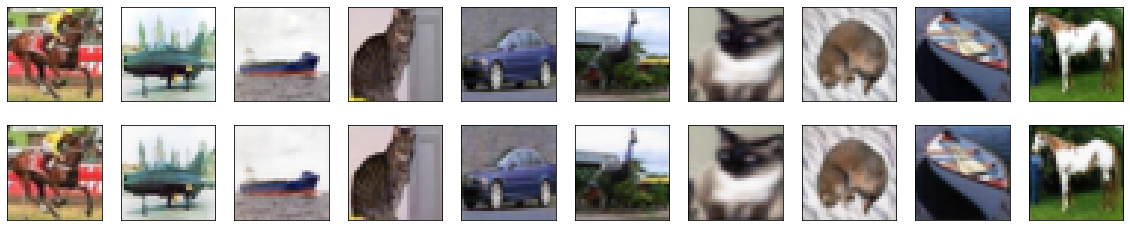

In [62]:
showOrigDec(x_valid, recon_valid_e2e)

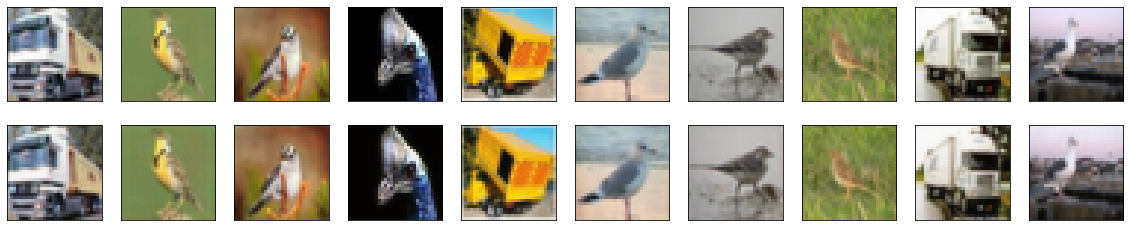

In [63]:
showOrigDec(x_test_final, recon_test_e2e)

Classification Report:

              precision    recall  f1-score   support

    Airplane       0.66      0.85      0.74      1000
  Automobile       0.76      0.92      0.83      1000
        Bird       0.82      0.65      0.73      3000
         Cat       0.46      0.64      0.53      1000
        Deer       0.85      0.71      0.77      3000
         Dog       0.63      0.69      0.66      1000
        Frog       0.66      0.86      0.75      1000
       Horse       0.68      0.83      0.75      1000
        Ship       0.85      0.88      0.86      1000
       Truck       0.96      0.82      0.88      3000

    accuracy                           0.76     16000
   macro avg       0.73      0.78      0.75     16000
weighted avg       0.79      0.76      0.77     16000



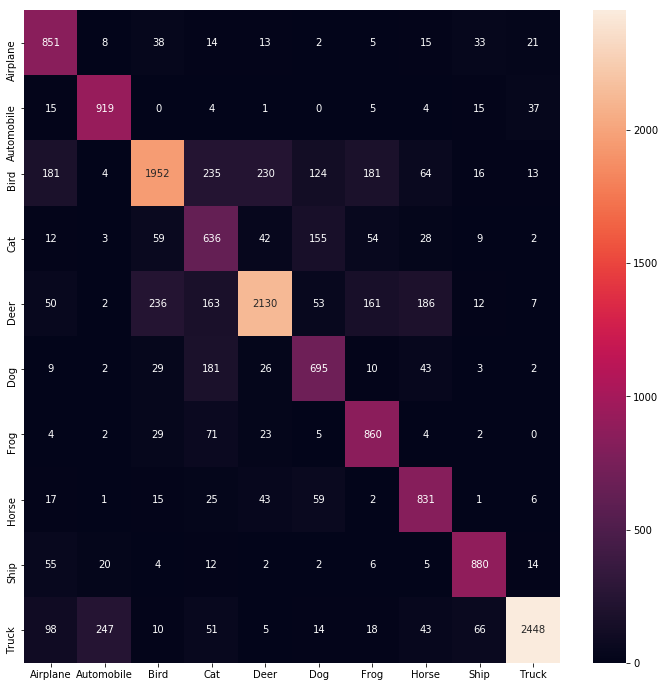

In [64]:
predictions = multimodel.predict(x_test_final)[1]
report(predictions)

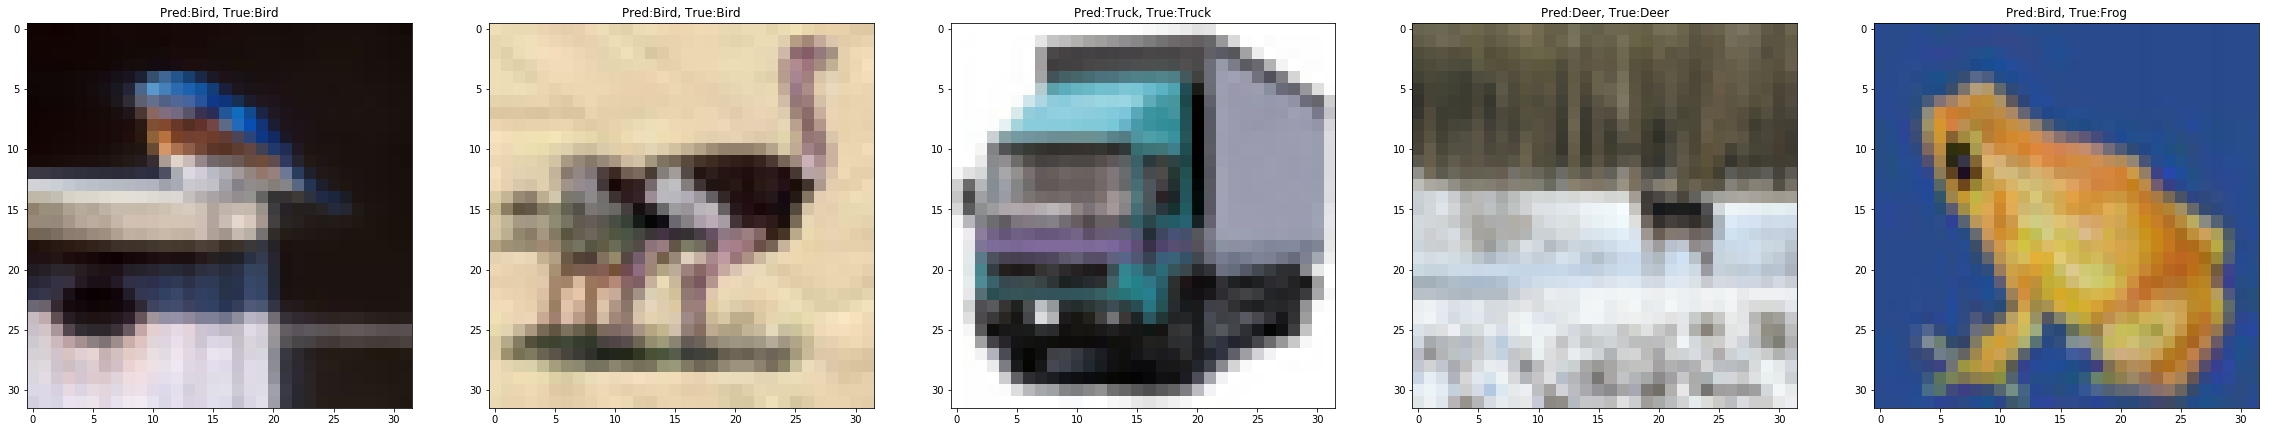

In [65]:
show_test2(multimodel, x_test_final)

Here, we trained a model that learns to generate the images and also classify them at the same time. We used a multi-output model for this task. The encoder part of the autoencoder model is shared for both the task to create similarity with how we did the classification in previous models where we used autoencoders as feature extractor. Also, we used loss_weights to give emphasis on the model to learn classification better. The autoencoder part of the model uses U-net architecture.

This multi-output model performs better than models where autoencoders were used as feature extractors, but not better than simple cnn models.

## Final Verdict:

1. Although, U-net is vastly superior as autoencoder compared to the convolutional autoencoder; the bottleneck features extracted from this model performs badly while classifying. The bottleneck features extracted from the simple convolutional AE model performs better in terms of classifications.

2. Convolution model with dense layer works better than stacked dense layers as classifier model.

3. Multioutput model, that share the encoder part of the autoencoder, works better than learning the autoencoder first and then learning to classify.

4. The baseline model without any autoencoder outperforms all the model.

5. The model can not classify the classes properly that had less training data.

## Future Works:

I have to experiment more with different classifier models and different hyperparameters. The extracted features are expected to have the most important gist of data of the images. So, I expected models with AE to outperform the baseline model. Also, although U-net model can almost perfectly reconstruct even images in the test dataset inspite of data imbalance, the bottleneck features extracted from it as input to different classifier models performed worst, which was a shock to me.

# Extra:

## Using sklearn models instead of neural networks:

The following code snippets were used for checking with different sklearn models as classifiers instead of neural networks. I used these to see if tree based models or svm performed better than neural networks to classify test images. But I found that neural networks performed better. Also, svm took a long time to run.

In [66]:
# def solvers(func):
#     scaler_classifier = MinMaxScaler(feature_range=(0.0, 1.0))
#     pipe = Pipeline(steps=[("scaler_classifier", scaler_classifier),
#                            ("classifier", func)])

#     pipe = pipe.fit(gist_train.reshape(gist_train.shape[0], -1), y_trainf)
#     acc = pipe.score(gist_test.reshape(gist_test.shape[0], -1), y_test_final)
#     predict = pipe.predict(gist_test.reshape(gist_test.shape[0], -1))
    
#     return acc, predict

In [67]:
# lr = LogisticRegression(C=5e-1, random_state=666, solver='lbfgs', multi_class='multinomial')
# rf = RandomForestClassifier(random_state=666)
# knn = KNeighborsClassifier()
# svc = svm.SVC()

In [68]:
# acc_lr, pred_lr = solvers(lr)
# acc_lr

In [69]:
# acc_rf, pred_rf = solvers(rf)
# acc_rf

In [70]:
# acc_knn, pred_knn = solvers(knn)
# acc_knn

In [71]:
# acc_svc, pred_svc = solvers(svc)
# acc_svc

## Hyperparameter Optimization:

The following code was used for hyperparameter optimization of the classifier model. The code was updated during various iterations to suit for different types of models used.

In [72]:
# space = {
#             'units1': hp.choice('units1', [256,512,1024]),
#             'units2': hp.choice('units2', [128,256,512]),
#             'units4': hp.choice('units4', [256,512,1024]),
#             'units5': hp.choice('units5', [50,64,100,128]),
#             'dropout1': hp.uniform('dropout1', .25,.75),
#             'dropout2': hp.uniform('dropout2', .25,.75),
#             'batch_size' : hp.choice('batch_size', [64,128,256,512]),
         
#             'nb_epochs' :  200,
#             'optimizer': hp.choice('optimizer',['adadelta','adam','rmsprop']),
#             'activation': 'relu'
#         }

In [73]:
# def f_nn(params):   
#     from keras.models import Sequential
#     from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, MaxPool2D, Flatten, BatchNormalization
#     from keras.layers import Input, Dense, Dropout, Activation, Add, Concatenate
#     from keras.optimizers import Adadelta, Adam, rmsprop
#     import sys

#     print ('Params testing: ', params)
#     model = Sequential()
#     model.add(Conv2D(params['units1'], 3, padding="same", activation="relu"))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D())
#     model.add(Conv2D(params['units2'], 3, padding="same", activation="relu"))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D())   

#     model.add(Flatten())
#     model.add(Dense(output_dim=params['units4'], activation="relu"))
#     model.add(Dropout(params['dropout1']))
#     model.add(Dense(output_dim=params['units5'], activation="relu"))
#     model.add(Dropout(params['dropout2']))
#     model.add(Dense(10))
#     model.add(Activation('softmax'))
#     model.compile(loss='categorical_crossentropy', optimizer=params['optimizer'], metrics=['accuracy'])

#     model.fit(gist_train, y_train, nb_epoch=params['nb_epochs'], batch_size=params['batch_size'], verbose = 0)

#     acc = model.evaluate(gist_valid, y_valid)[1]
#     print('Accuracy:', acc)
#     sys.stdout.flush() 
#     return {'loss': -acc, 'status': STATUS_OK}


# trials = Trials()
# best = fmin(f_nn, space, algo=tpe.suggest, max_evals=5, trials=trials)
# print('best: ')
# print(best)